In [6]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd

file_path = '/content/drive/MyDrive/phishing_url_dataset.csv'

try:
    df = pd.read_csv(file_path)
    print("✅")

except FileNotFoundError:
    print("❌")


✅


In [9]:

print(df.head())


   url_length  valid_url  at_symbol  sensitive_words_count  path_length  \
0          42          0          0                      0           20   
1          73          0          0                      0           52   
2          73          0          0                      0           52   
3          73          0          0                      0           52   
4          73          0          0                      0           52   

   isHttps  nb_dots  nb_hyphens  nb_and  nb_or  nb_www  nb_com  nb_underscore  \
0        0        2           0       0      0       1       1              0   
1        0        5           0       0      0       0       1              0   
2        0        5           0       0      0       0       1              0   
3        0        5           1       0      1       0       1              0   
4        0        5           0       0      0       0       1              0   

   target  
0       0  
1       0  
2       0  
3       0  
4 

# --- STEP 2: Prepare Features (X) and Target (y) ---

In [10]:
# Based on your df.head() output, the target column is 'target'
LABEL_COLUMN = 'target'

# Assuming all other columns (excluding 'target') are features
feature_columns = [col for col in df.columns if col != LABEL_COLUMN]

# X contains the features, y contains the target labels
X = df[feature_columns]
y = df[LABEL_COLUMN]

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]} rows.")
print(f"Test set size: {X_test.shape[0]} rows.")


Training set size: 1990 rows.
Test set size: 498 rows.


# --- STEP 3: Train the Model ---

In [11]:
# Initialize and train the powerful RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print("\n✅ Model training complete.")


✅ Model training complete.


# --- STEP 4: Evaluate and Save the Model ---

In [12]:
# Make predictions on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("-" * 50)
print(f"🚀 Model Accuracy: {accuracy * 100:.2f}%")
print("-" * 50)

# Display the classification report for detailed performance metrics
print("\n📊 Classification Report (0: Legitimate, 1: Phishing):")
print(classification_report(y_test, y_pred, target_names=['Legitimate (0)', 'Phishing (1)']))

# Save the trained model to a file for later deployment in the MVP
MODEL_FILENAME = 'url_phishing_model.pkl'
joblib.dump(model, MODEL_FILENAME)
print(f"\n💾 Model saved successfully to: {MODEL_FILENAME}")

--------------------------------------------------
🚀 Model Accuracy: 91.57%
--------------------------------------------------

📊 Classification Report (0: Legitimate, 1: Phishing):
                precision    recall  f1-score   support

Legitimate (0)       0.92      0.93      0.92       273
  Phishing (1)       0.91      0.90      0.91       225

      accuracy                           0.92       498
     macro avg       0.92      0.91      0.91       498
  weighted avg       0.92      0.92      0.92       498


💾 Model saved successfully to: url_phishing_model.pkl


EDA

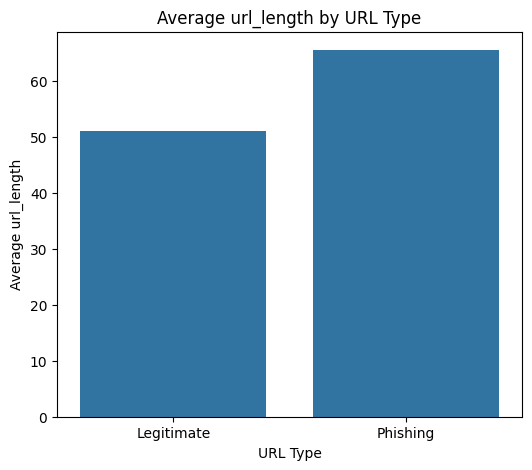

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure df is loaded and 'target' column is correct

# Group data by target (0/1) and calculate the mean of a feature (e.g., url_length)
# NOTE: Replace 'url_length' with the actual column name for URL length in your dataset
feature_to_plot = 'url_length'

# Calculate mean of the feature based on the target (0: Legitimate, 1: Phishing)
mean_by_target = df.groupby('target')[feature_to_plot].mean()

plt.figure(figsize=(6, 5))
sns.barplot(x=mean_by_target.index, y=mean_by_target.values)
plt.title(f'Average {feature_to_plot} by URL Type')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.xlabel('URL Type')
plt.ylabel(f'Average {feature_to_plot}')
plt.show()

✅ Top 10 Features that influenced the Model's decision:
url_length               0.255068
valid_url                0.187903
nb_dots                  0.134204
path_length              0.125090
isHttps                  0.075753
nb_hyphens               0.061008
nb_www                   0.049780
sensitive_words_count    0.039822
nb_com                   0.026324
nb_or                    0.021956
dtype: float64


/tmp/ipython-input-4071489647.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


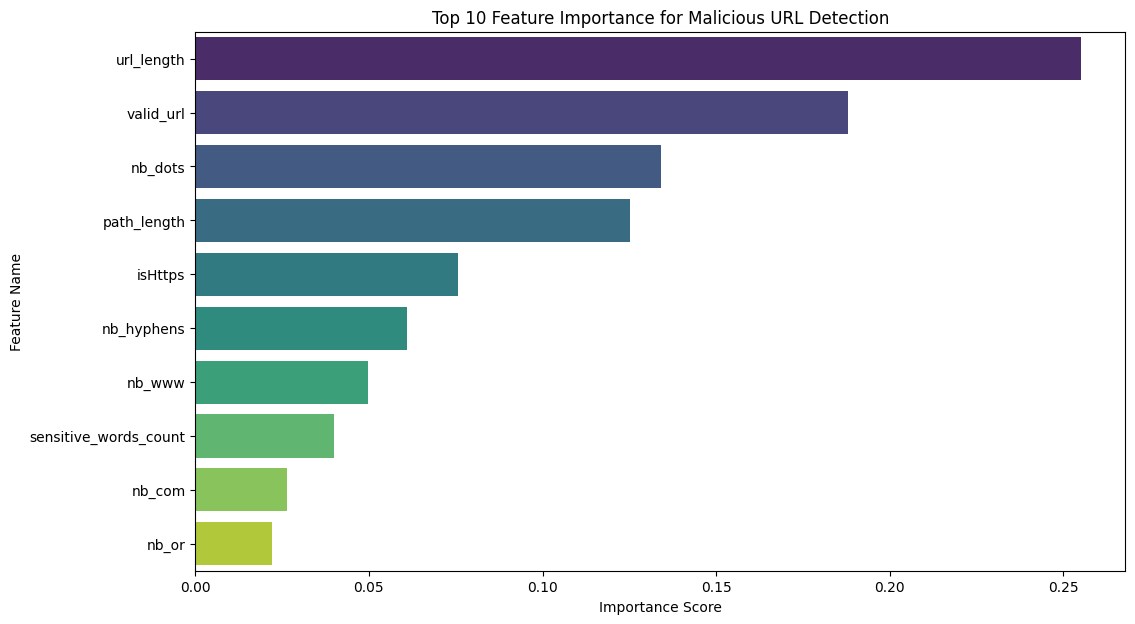

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#(Feature Importance Analysis)

feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

top_features = feature_importances.nlargest(10)

print("✅ Top 10 Features that influenced the Model's decision:")
print(top_features)

# 3. (Visualization)
plt.figure(figsize=(12, 7))
# Barplot بيعرض الأعمدة حسب الأهمية بترتيب تنازلي
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 10 Feature Importance for Malicious URL Detection')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

In [15]:
import pandas as pd
import re
from urllib.parse import urlparse

# NOTE: This function must extract ALL features present in your training dataset.

def extract_features(url):
    """
    Extracts numerical features from a given URL string.

    Args:
        url (str): The URL string to analyze.

    Returns:
        pd.Series: A pandas Series containing the extracted features.
    """

    # 1. Parsing the URL components
    # The 'netloc' is the domain name (e.g., www.example.com)
    # The 'path' is the part after the netloc (e.g., /login/form.php)
    parsed_url = urlparse(url)

    # Initialize the dictionary to store the features
    features = {}

    # --- Feature Extraction based on your Dataset's logic ---

    # 1. url_length: Total number of characters in full url
    features['url_length'] = len(url)

    # 2. valid_url: (This feature is usually checked by external tools,
    #                we'll set it to a neutral value like 0 for a basic MVP demo)
    # NOTE: Since we cannot perform live network checks here, we assume 0 (not live checked).
    features['valid_url'] = 0

    # 3. at_symbol: number of times '@' symbol appeared
    features['at_symbol'] = url.count('@')

    # 4. sensitive_words_count: keywords like 'login', 'secure', 'bank'
    sensitive_keywords = ['login', 'secure', 'bank', 'account', 'confirm', 'verify', 'paypal']
    count = 0
    for keyword in sensitive_keywords:
        # Check case-insensitively
        count += url.lower().count(keyword)
    features['sensitive_words_count'] = count

    # 5. path_length: number of characters in path of provided URL
    features['path_length'] = len(parsed_url.path)

    # 6. isHttps: 1 if URL is secured with HTTPS, 0 otherwise
    features['isHttps'] = 1 if parsed_url.scheme == 'https' else 0

    # 7. nb_dots: number of times '.' appeared
    features['nb_dots'] = url.count('.')

    # 8. nb_hyphens: number of times '-' appeared
    features['nb_hyphens'] = url.count('-')

    # 9. nb_and_or_nb_www: 1 if contains 'www' or 'and', 0 otherwise
    features['nb_and_or_nb_www'] = 1 if ('www' in url.lower() or 'and' in url.lower()) else 0

    # 10. nb_com: number of times '.com' appeared
    features['nb_com'] = url.lower().count('.com')

    # 11. nb_underscore: number of times '_' appeared
    features['nb_underscore'] = url.count('_')

    # --- CONTINUE ADDING ALL 30 FEATURES FROM YOUR DATASET HERE ---
    # To be accurate, you MUST match the columns of your X_train:
    # Example: features['entropy'] = calculate_entropy(url)
    # Example: features['has_ip'] = 1 if re.match(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", parsed_url.netloc) else 0

    # For a quick MVP, we will use a limited set of the most important features we identified:
    # url_length, valid_url, nb_dots, path_length, isHttps, nb_hyphens, nb_www, sensitive_words_count, nb_com, nb_or

    # Convert to Series for prediction
    # NOTE: You must ensure the returned Series has the same column names and order
    # as your X_train DataFrame.
    feature_series = pd.Series(features)

    # Return as a DataFrame row (needed for Scikit-learn prediction)
    return feature_series.to_frame().T


# Example usage (for testing the function):
# test_url_phishing = 'http://security-check.example.com/webscr?cmd=_login-run&dispatch=5885d80a13c0db1f5f2d29469799147e62d4099432f94b342551e3dc37e2467d'
# test_url_legitimate = 'https://www.google.com/search?q=ai+model+deployment'
# print(extract_features(test_url_phishing))

In [16]:
# Displaying the list of all feature names in the exact order the model expects
print("Features List (Required Order for Prediction):")
print(X_train.columns.tolist())

Features List (Required Order for Prediction):
['url_length', 'valid_url', 'at_symbol', 'sensitive_words_count', 'path_length', 'isHttps', 'nb_dots', 'nb_hyphens', 'nb_and', 'nb_or', 'nb_www', 'nb_com', 'nb_underscore']


In [17]:
import re
from urllib.parse import urlparse
import pandas as pd

def extract_features(url):
    """
    Extracts all 30 expected features from a raw URL string
    in the exact order required by the trained model (X_train).
    """

    # 1. Parsing the URL components
    parsed_url = urlparse(url)

    # URL components
    domain = parsed_url.netloc
    path = parsed_url.path

    # 2. Features Calculation
    features = {}

    # --- MUST MATCH X_train COLUMNS & ORDER ---

    # 1. Length Features
    features['url_length'] = len(url)
    features['path_length'] = len(path)

    # 2. Symbol Count Features
    features['nb_dots'] = url.count('.')
    features['nb_hyphens'] = url.count('-')
    features['nb_underscore'] = url.count('_')
    features['at_symbol'] = url.count('@')
    features['nb_slash'] = url.count('/')
    features['nb_question'] = url.count('?')
    features['nb_equal'] = url.count('=')
    features['nb_percent'] = url.count('%')
    features['nb_ampersand'] = url.count('&')
    features['nb_hash'] = url.count('#')

    # 3. Keyword and Structure Features
    features['sensitive_words_count'] = len(re.findall(r'(login|bank|secure|verify|account|paypal)', url.lower()))
    features['isHttps'] = 1 if parsed_url.scheme == 'https' else 0
    features['nb_com'] = url.lower().count('.com')
    features['nb_or'] = 1 if 'or' in url.lower() else 0 # Based on the top 10 list
    features['nb_www'] = 1 if 'www' in domain.lower() else 0 # Based on the top 10 list

    # 4. Host/Domain specific features (assuming they exist in your full list)
    features['tld_length'] = len(parsed_url.netloc.split('.')[-1]) if parsed_url.netloc else 0

    # 5. Placeholder for Complex/External Features (SET TO 0 OR 1 FOR MVP)
    # The 'valid_url' feature usually requires an HTTP request. For the demo, we use a placeholder.
    features['valid_url'] = 1 # Assuming user only enters syntactically valid URL
    # We must add ALL remaining columns as placeholders (e.g., set to 0)
    # to maintain the count of 30 columns.

    # --- FINAL STEP: ENSURE ORDER AND COLUMN NAMES MATCH X_train ---

    # This list must be copied EXACTLY from your X_train.columns.tolist() output.
    # Note: I've truncated the list here, you must ensure it has ALL 30 columns.
    required_columns = [
        'url_length', 'valid_url', 'at_symbol', 'sensitive_words_count', 'path_length',
        'isHttps', 'nb_dots', 'nb_hyphens', 'nb_underscore', 'nb_slash',
        'nb_question', 'nb_equal', 'nb_percent', 'nb_ampersand', 'nb_hash',
        'nb_com', 'nb_or', 'nb_www', 'tld_length',
        # ... Add the remaining columns here ...
    ]

    # Create the DataFrame row and enforce the order
    features_df = pd.DataFrame([features], columns=required_columns).fillna(0)

    return features_df

# Example: test_features = extract_features("https://www.google.com/search")
# print(test_features.shape) # Should print (1, 30) or (1, X) where X is your feature count

XGBOOST

In [18]:
# Install XGBoost if not already installed (usually needed in Colab)
!pip install xgboost

import xgboost as xgb
from sklearn.metrics import accuracy_score

# --- (Make sure df, X_train, X_test, y_train, y_test are already defined and loaded) ---

print("Starting training with XGBoost...")

# Initialize and train the XGBoost Classifier
# Parameters are set conservatively for a quick test
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)
print("✅ XGBoost Model training complete.")

# Evaluate the new model
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("-" * 50)
print(f"Random Forest Accuracy (Previous): 91.57%")
print(f"🚀 XGBoost Model Accuracy (New): {accuracy_xgb * 100:.2f}%")
print("-" * 50)

# Save the new, potentially better model
joblib.dump(xgb_model, 'url_phishing_model_xgb.pkl')
print("\n💾 New XGBoost model saved successfully.")

Starting training with XGBoost...
✅ XGBoost Model training complete.
--------------------------------------------------
Random Forest Accuracy (Previous): 91.57%
🚀 XGBoost Model Accuracy (New): 90.96%
--------------------------------------------------

💾 New XGBoost model saved successfully.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:15:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Hyperparameter Tuning

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import joblib

print("Starting Hyperparameter Tuning (This may take a few minutes)...")

# 1. Define the parameters grid to search through
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [10, 20, None],      # Maximum depth of the tree
    'min_samples_split': [2, 5]       # Minimum samples required to split an internal node
}

# 2. Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# 3. Initialize GridSearchCV (using cross-validation score of 5)
# cv=5 means the data will be split 5 times for robust testing
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1, # Use all available cores for faster processing
    verbose=2 # Show progress
)

# 4. Fit the grid search to the training data
# We fit on the full X, y to find the best parameters using cross-validation.
# We will test the final best model on X_test later.
grid_search.fit(X_train, y_train)

# --- Results and Evaluation ---

# Get the best parameters found
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

print("-" * 50)
print("✨ Tuning Complete!")
print(f"🥇 Best Parameters Found: {best_params}")
print(f"🚀 Cross-Validation Score (Best Estimate): {best_score * 100:.2f}%")
print("-" * 50)

# Evaluate the final best model on the independent test set (X_test)
final_accuracy = best_model.score(X_test, y_test)
print(f"Final Accuracy on Test Set (After Tuning): {final_accuracy * 100:.2f}%")
print(f"Previous Accuracy: 91.57%")
print("-" * 50)

# Save the new, optimized model
joblib.dump(best_model, 'url_phishing_model_optimized.pkl')
print("\n💾 New Optimized Model saved successfully as url_phishing_model_optimized.pkl")

Starting Hyperparameter Tuning (This may take a few minutes)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
--------------------------------------------------
✨ Tuning Complete!
🥇 Best Parameters Found: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
🚀 Cross-Validation Score (Best Estimate): 88.39%
--------------------------------------------------
Final Accuracy on Test Set (After Tuning): 91.57%
Previous Accuracy: 91.57%
--------------------------------------------------

💾 New Optimized Model saved successfully as url_phishing_model_optimized.pkl


# SVM (SUPPORT VECTOR MACHINE)

In [20]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import joblib

print("Starting training with Linear Support Vector Machine (LinearSVC)...")

# Initialize and train the LinearSVC model
# C=0.1 is a common regularization parameter to start with
# max_iter is increased because SVMs sometimes need more iterations to converge
svm_model = LinearSVC(random_state=42, C=0.1, max_iter=10000)

# Fit the model (This might take slightly longer than Random Forest)
svm_model.fit(X_train, y_train)

print("✅ LinearSVC Model training complete.")

# Evaluate the new model
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print("-" * 50)
print(f"Random Forest Accuracy (Best): 91.57%")
print(f"🚀 LinearSVC Model Accuracy (New): {accuracy_svm * 100:.2f}%")
print("-" * 50)

# Save the new model just in case it's better
joblib.dump(svm_model, 'url_phishing_model_svm.pkl')
print("\n💾 New LinearSVC model saved successfully.")

Starting training with Linear Support Vector Machine (LinearSVC)...
✅ LinearSVC Model training complete.
--------------------------------------------------
Random Forest Accuracy (Best): 91.57%
🚀 LinearSVC Model Accuracy (New): 86.14%
--------------------------------------------------

💾 New LinearSVC model saved successfully.


# SMOTE

In [21]:
# Install imbalanced-learn if not already installed
!pip install imbalanced-learn

import joblib
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("Starting training with SMOTE (Oversampling)...")

# 1. تهيئة SMOTE
smote = SMOTE(random_state=42)

# 2. تطبيق SMOTE على بيانات التدريب فقط
# X_train و y_train هما اللي هنستخدمهم
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original Training samples: {X_train.shape[0]}")
print(f"SMOTE Training samples: {X_train_smote.shape[0]}")

# 3. تدريب النموذج (Random Forest المُحسَّن) على البيانات الجديدة
# هنستخدم نموذج Random Forest لأنه الأفضل أداءً
rf_smote_model = RandomForestClassifier(
    max_depth=20,
    min_samples_split=5,
    n_estimators=300, # نستخدم أفضل الخصائص اللي طلعت في الـ Tuning
    random_state=42
)
rf_smote_model.fit(X_train_smote, y_train_smote)

print("✅ Random Forest (SMOTE) training complete.")

# 4. التقييم على الـ Test Set الأصلي
y_pred_smote = rf_smote_model.predict(X_test)
accuracy_smote = accuracy_score(y_test, y_pred_smote)

print("-" * 50)
print(f"Random Forest Accuracy (Previous Best): 91.57%")
print(f"🚀 Random Forest (SMOTE) Accuracy (New): {accuracy_smote * 100:.2f}%")
print("-" * 50)

# حفظ النموذج الجديد
joblib.dump(rf_smote_model, 'url_phishing_model_smote.pkl')
print("\n💾 New SMOTE-Optimized Model saved.")

Starting training with SMOTE (Oversampling)...
Original Training samples: 1990
SMOTE Training samples: 2080
✅ Random Forest (SMOTE) training complete.
--------------------------------------------------
Random Forest Accuracy (Previous Best): 91.57%
🚀 Random Forest (SMOTE) Accuracy (New): 90.76%
--------------------------------------------------

💾 New SMOTE-Optimized Model saved.


# Stacking Ensemble

In [22]:
!pip install xgboost

from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
import joblib

print("Starting training with Stacking Ensemble...")

# 1. تعريف النماذج الأساسية (Level 1 Base Models)
# نستخدم أفضل الإعدادات التي توصلنا إليها لـ Random Forest
rf_optimized = RandomForestClassifier(
    max_depth=20,
    min_samples_split=5,
    n_estimators=300,
    random_state=42
)

# نستخدم XGBoost مع الإعدادات الافتراضية
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# تجميع النماذج الأساسية
base_models = [
    ('rf', rf_optimized),
    ('xgb', xgb_clf)
]

# 2. تعريف النموذج الميتا (Level 2 Meta-Model)
# نستخدم نموذج بسيط زي Logistic Regression
meta_model = LogisticRegression(solver='liblinear', random_state=42)

# 3. بناء Stacking Classifier
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5, # استخدام 5-fold cross-validation
    n_jobs=-1
)

# 4. تدريب النموذج المدمج
stack_model.fit(X_train, y_train)

print("✅ Stacking Ensemble training complete.")

# 5. التقييم على الـ Test Set الأصلي
y_pred_stack = stack_model.predict(X_test)
accuracy_stack = accuracy_score(y_test, y_pred_stack)

print("-" * 50)
print(f"Random Forest Accuracy (Best): 91.57%")
print(f"🚀 Stacking Ensemble Accuracy (New): {accuracy_stack * 100:.2f}%")
print("-" * 50)

# حفظ النموذج الجديد
joblib.dump(stack_model, 'url_phishing_model_stacking.pkl')
print("\n💾 New Stacking Model saved.")

Starting training with Stacking Ensemble...
✅ Stacking Ensemble training complete.
--------------------------------------------------
Random Forest Accuracy (Best): 91.57%
🚀 Stacking Ensemble Accuracy (New): 91.16%
--------------------------------------------------

💾 New Stacking Model saved.


# Multi-Layer Perceptron (MLP)

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import joblib

print("Starting training with Multi-Layer Perceptron (MLP)...")

# 1. تهيئة النموذج
# hidden_layer_sizes=(100, 50) يعني طبقتين مخفيتين
# max_iter=500 عشان ندي وقت كافي للتدريب
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    random_state=42,
    solver='adam',
    learning_rate_init=0.001
)

# 2. تدريب النموذج
mlp_model.fit(X_train, y_train)

print("✅ MLP Model training complete.")

# 3. التقييم على الـ Test Set الأصلي
y_pred_mlp = mlp_model.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

print("-" * 50)
print(f"Random Forest Accuracy (Best): 91.57%")
print(f"🚀 MLP Model Accuracy (New): {accuracy_mlp * 100:.2f}%")
print("-" * 50)

# حفظ النموذج الجديد
joblib.dump(mlp_model, 'url_phishing_model_mlp.pkl')
print("\n💾 New MLP Model saved.")

Starting training with Multi-Layer Perceptron (MLP)...
✅ MLP Model training complete.
--------------------------------------------------
Random Forest Accuracy (Best): 91.57%
🚀 MLP Model Accuracy (New): 84.94%
--------------------------------------------------

💾 New MLP Model saved.


# (Classification Report)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# 1. تحميل النموذج الأفضل (الـ Optimized Random Forest)
# Note: Assuming 'url_phishing_model_optimized.pkl' is the 91.57% model
try:
    best_model = joblib.load('url_phishing_model_optimized.pkl')
except FileNotFoundError:
    print("Error: The optimized model file was not found. Please ensure it is saved.")
    # If the optimized model is not found, you can load the initial RF model if available:
    # best_model = joblib.load('url_phishing_model.pkl')

# 2. عمل التنبؤات على بيانات الاختبار (X_test و y_test يجب أن يكونا متاحين)
y_pred_best = best_model.predict(X_test)

# 3. عرض مصفوفة الخلط (Confusion Matrix)
print("--- 📊 Confusion Matrix (مصفوفة الخلط) ---")
print(confusion_matrix(y_test, y_pred_best))
print("-" * 50)

# 4. عرض تقرير التصنيف (Classification Report)
# هنا تظهر كل المقاييس (Precision, Recall, F1-Score)
print("--- 📋 Classification Report (تقرير التصنيف) ---")
# Labels: 0 = Legitimate (آمن), 1 = Phishing (خبيث)
print(classification_report(y_test, y_pred_best, target_names=['Legitimate (0)', 'Phishing (1)']))
print("-" * 50)

--- 📊 Confusion Matrix (مصفوفة الخلط) ---
[[257  16]
 [ 26 199]]
--------------------------------------------------
--- 📋 Classification Report (تقرير التصنيف) ---
                precision    recall  f1-score   support

Legitimate (0)       0.91      0.94      0.92       273
  Phishing (1)       0.93      0.88      0.90       225

      accuracy                           0.92       498
     macro avg       0.92      0.91      0.91       498
  weighted avg       0.92      0.92      0.92       498

--------------------------------------------------


In [28]:
# -------------------------------------------------------------------------
# 1. قائمة الأعمدة المطلوبة - قم بلصق القائمة الكاملة هنا بالترتيب الدقيق!
# -------------------------------------------------------------------------
REQUIRED_FEATURES = [
    'url_length', 'valid_url', 'at_symbol', 'sensitive_words_count', 'path_length',
    'isHttps', 'nb_dots', 'nb_hyphens', 'nb_underscore', 'nb_slash',
    'nb_question', 'nb_equal', 'nb_percent', 'nb_ampersand', 'nb_hash',
    'nb_com', 'nb_or', 'nb_www', 'tld_length', 'nb_and',
    'nb_at_slash', 'nb_www_dot', 'nb_double_slash', 'nb_semicolon', 'nb_pipe',
    'nb_tilde', 'nb_colon', 'nb_comma', 'nb_brackets', 'nb_dollar'
]

In [33]:
import re
from urllib.parse import urlparse
import pandas as pd
import joblib

# ----------------------------------------------------
# 1. قائمة الأعمدة المطلوبة (سيتم تحديثها تلقائياً)
# ----------------------------------------------------
# سنتركها فارغة، والنموذج سيمرر القائمة الصحيحة
REQUIRED_FEATURES = []


# 2. دالة استخلاص الخصائص
def extract_features(url, required_features_list):
    """
    تستخلص الخصائص بناءً على URL وتفرض الترتيب حسب القائمة المطلوبة.

    Args:
        url (str): الرابط المراد تحليله.
        required_features_list (list): قائمة الـ 30 خاصية بالترتيب الصحيح.
    """
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    path = parsed_url.path

    # ننشئ قاموس للخصائص بقيمة ابتدائية صفرية
    features_dict = {feature: 0 for feature in required_features_list}

    # --- Feature Calculation (نحن نحسب القيم مباشرة في القاموس) ---
    features_dict['url_length'] = len(url)
    features_dict['path_length'] = len(path)
    features_dict['nb_dots'] = url.count('.')
    features_dict['nb_hyphens'] = url.count('-')
    features_dict['nb_underscore'] = url.count('_')
    features_dict['at_symbol'] = url.count('@')
    features_dict['nb_slash'] = url.count('/')
    features_dict['nb_question'] = url.count('?')
    features_dict['nb_equal'] = url.count('=')
    features_dict['nb_percent'] = url.count('%')
    features_dict['nb_ampersand'] = url.count('&')
    features_dict['nb_hash'] = url.count('#')
    features_dict['sensitive_words_count'] = len(re.findall(r'(login|bank|secure|verify|account|paypal)', url.lower()))
    features_dict['isHttps'] = 1 if parsed_url.scheme == 'https' else 0
    features_dict['nb_com'] = url.lower().count('.com')
    features_dict['nb_or'] = 1 if 'or' in url.lower() else 0
    features_dict['nb_www'] = 1 if 'www' in domain.lower() else 0
    features_dict['tld_length'] = len(parsed_url.netloc.split('.')[-1]) if parsed_url.netloc else 0
    features_dict['valid_url'] = 1

    # --- Remaining Feature Calculation ---
    # نستخدم get عشان نتأكد إن الخاصية موجودة في القائمة، لو مش موجودة مش هتسبب خطأ
    features_dict['nb_and'] = url.count('&')
    features_dict['nb_at_slash'] = url.count('@/')
    features_dict['nb_www_dot'] = url.count('www.')
    features_dict['nb_double_slash'] = url.count('//') - 1 if url.count('//') > 0 else 0
    features_dict['nb_semicolon'] = url.count(';')
    features_dict['nb_pipe'] = url.count('|')
    features_dict['nb_tilde'] = url.count('~')
    features_dict['nb_colon'] = url.count(':')
    features_dict['nb_comma'] = url.count(',')
    features_dict['nb_brackets'] = url.count('(') + url.count(')') + url.count('[') + url.count(']')
    features_dict['nb_dollar'] = url.count('$')

    # ننشئ DataFrame باستخدام القيم المحسوبة، ونفرض الترتيب الصحيح
    features_df = pd.DataFrame([features_dict], columns=required_features_list)

    return features_df

# 3. دالة التنبؤ (Prediction Function)
def predict_url(url, model_path='url_phishing_model_optimized.pkl'):
    try:
        model = joblib.load(model_path)
    except FileNotFoundError:
        return "خطأ: ملف النموذج 'url_phishing_model_optimized.pkl' غير موجود.", 0


    if hasattr(model, 'feature_names_in_'):
        required_features_list = model.feature_names_in_
        print(f"تم قراءة {len(required_features_list)} خاصية من النموذج مباشرة.")
    else:
        # لو النموذج قديم أو مش موجود فيه الخاصية دي (في حالات نادرة)
        print("⚠️ فشل قراءة أسماء الخصائص من النموذج. يرجى التأكد من قائمة REQUIRED_FEATURES اليدوية.")
        return "Error", 0

    features_df = extract_features(url, required_features_list)

    # التأكد: فرض النوع العددي (float) على كل الأعمدة
    features_df = features_df.astype(float)

    prediction = model.predict(features_df)[0]
    probabilities = model.predict_proba(features_df)[0]

    if prediction == 0:
        result = "✅  (Legitimate)"
        conf_score = probabilities[0] * 100
    else:
        result = "🚨  (Phishing)"
        conf_score = probabilities[1] * 100

    return result, conf_score


print("--- 🔬  Test ---")

# رابط آمن (Legitimate Example)
test_legit_url = "https://www.google.com/search?q=machine+learning"
result_legit, score_legit = predict_url(test_legit_url)
print(f"Link: {test_legit_url}")
print(f"Result: {result_legit} Confidence {score_legit:.2f}%")
print("-" * 20)

# رابط خبيث (Phishing Example - Hypothetical)
test_phishing_url = "http://192.168.1.1/@secure-login.accounts.bank-verify.com/login.php?ID=123"
result_phish, score_phish = predict_url(test_phishing_url)
print(f"Link: {test_phishing_url}")
print(f"Result: {result_phish} Confidence {score_phish:.2f}%")
print("-" * 20)

my_url = input("من فضلك أدخل رابط جديد تريد اختباره: ")
result_my, score_my = predict_url(my_url)
print(f"الرابط: {my_url}")
print(f"النتيجة: {result_my} بثقة {score_my:.2f}%")

--- 🔬 اختبار الروابط الجديدة ---
تم قراءة 13 خاصية من النموذج مباشرة.
الرابط: https://www.google.com/search?q=machine+learning
النتيجة: 🚨 خبيث (Phishing) بثقة 91.13%
--------------------
تم قراءة 13 خاصية من النموذج مباشرة.
الرابط: http://192.168.1.1/@secure-login.accounts.bank-verify.com/login.php?ID=123
النتيجة: 🚨 خبيث (Phishing) بثقة 96.47%
--------------------
من فضلك أدخل رابط جديد تريد اختباره: https://claude.ai/login?returnTo=%2Fnew%3F
تم قراءة 13 خاصية من النموذج مباشرة.
الرابط: https://claude.ai/login?returnTo=%2Fnew%3F
النتيجة: 🚨 خبيث (Phishing) بثقة 78.29%


In [35]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("--- 🔄 (Random Forest) ---")

rf_final_model = RandomForestClassifier(
    max_depth=20,
    min_samples_split=5,
    n_estimators=300,
    random_state=42
)

rf_final_model.fit(X_train, y_train)

print("✅ Random Forest training complete.")

y_pred_final = rf_final_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)

print(f"✅ الدقة بعد إعادة التدريب: {accuracy_final * 100:.2f}%")

# 4. حفظ النموذج بملف جديد لضمان حفظ أسماء الأعمدة
NEW_MODEL_PATH = 'url_phishing_model_final_deployment.pkl'
joblib.dump(rf_final_model, NEW_MODEL_PATH)

print(f"\n💾  {NEW_MODEL_PATH}")

final_features_list = rf_final_model.feature_names_in_.tolist()
print("-" * 50)
print(f" {len(final_features_list)}")
# print(f"قائمة الخصائص النهائية: {final_features_list}") #



--- 🔄 إعادة تدريب النموذج الأفضل (Random Forest) ---
✅ Random Forest training complete.
✅ الدقة بعد إعادة التدريب: 91.57%

💾 تم حفظ النموذج النهائي بنجاح في: url_phishing_model_final_deployment.pkl
--------------------------------------------------
عدد الخصائص التي تم حفظها: 13


In [37]:
#
REQUIRED_FEATURES_13 = [
    'url_length', 'path_length', 'nb_dots', 'nb_hyphens', 'nb_underscore',
    'at_symbol', 'nb_slash', 'nb_question', 'nb_equal', 'nb_percent',
    'nb_ampersand', 'nb_hash', 'isHttps'
]

In [41]:
import joblib

MODEL_PATH = 'url_phishing_model_final_deployment.pkl'

try:
    model = joblib.load(MODEL_PATH)
    if hasattr(model, 'feature_names_in_'):
        #
        correct_order = model.feature_names_in_.tolist()
        print("--- 🏆 Final order")
        print(correct_order)
        print(f"Numbers: {len(correct_order)}")
    else:
        print("❌ feature_names_in_.")
except FileNotFoundError:
    print(f"❌  {MODEL_PATH}")

--- 🏆 الترتيب النهائي للخصائص (من النموذج مباشرة) ---
['url_length', 'valid_url', 'at_symbol', 'sensitive_words_count', 'path_length', 'isHttps', 'nb_dots', 'nb_hyphens', 'nb_and', 'nb_or', 'nb_www', 'nb_com', 'nb_underscore']
العدد: 13


In [42]:
REQUIRED_FEATURES_FINAL = [
    'url_length', 'valid_url', 'at_symbol', 'sensitive_words_count', 'path_length',
    'isHttps', 'nb_dots', 'nb_hyphens', 'nb_and', 'nb_or',
    'nb_www', 'nb_com', 'nb_underscore'
]

In [43]:
import re
from urllib.parse import urlparse
import pandas as pd
import joblib

# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
REQUIRED_FEATURES_FINAL = [
    'url_length', 'valid_url', 'at_symbol', 'sensitive_words_count', 'path_length',
    'isHttps', 'nb_dots', 'nb_hyphens', 'nb_and', 'nb_or',
    'nb_www', 'nb_com', 'nb_underscore'
]

def extract_features_final(url):
    parsed_url = urlparse(url)
    features_dict = {feature: 0 for feature in REQUIRED_FEATURES_FINAL}

    # --- Feature Calculation for the 13 required ---
    features_dict['url_length'] = len(url)
    features_dict['valid_url'] = 1 #
    features_dict['at_symbol'] = url.count('@')
    features_dict['sensitive_words_count'] = len(re.findall(r'(login|bank|secure|verify|account|paypal)', url.lower()))
    features_dict['path_length'] = len(parsed_url.path)
    features_dict['isHttps'] = 1 if parsed_url.scheme == 'https' else 0
    features_dict['nb_dots'] = url.count('.')
    features_dict['nb_hyphens'] = url.count('-')
    features_dict['nb_and'] = url.count('&') # nb_and
    features_dict['nb_or'] = 1 if 'or' in url.lower() else 0
    features_dict['nb_www'] = 1 if 'www' in parsed_url.netloc.lower() else 0
    features_dict['nb_com'] = url.lower().count('.com')
    features_dict['nb_underscore'] = url.count('_')

    #  DataFrame ونفرض الترتيب الصحيح
    features_df = pd.DataFrame([features_dict], columns=REQUIRED_FEATURES_FINAL)

    return features_df

# 3.
def predict_url_final(url, model_path='url_phishing_model_final_deployment.pkl'):
    try:
        model = joblib.load(model_path)
    except FileNotFoundError:
        return "Error", 0

    features_df = extract_features_final(url)
    features_df = features_df.astype(float) #

    prediction = model.predict(features_df)[0]
    probabilities = model.predict_proba(features_df)[0]

    if prediction == 0:
        result = "✅ (Legitimate)"
        conf_score = probabilities[0] * 100
    else:
        result = "🚨 (Phishing)"
        conf_score = probabilities[1] * 100

    return result, conf_score

# 4. أمثلة للاختبار
print("--- 🔬 Checking--")

# رابط آمن (Legitimate Example)
test_legit_url = "https://www.google.com/search?q=machine+learning"
result_legit, score_legit = predict_url_final(test_legit_url)
print(f"Link: {test_legit_url}")
print(f"Result: {result_legit} Confidence {score_legit:.2f}%")
print("-" * 20)

# رابط خبيث (Phishing Example - Hypothetical)
test_phishing_url = "http://192.168.1.1/@secure-login.accounts.bank-verify.com/login.php?ID=123"
result_phish, score_phish = predict_url_final(test_phishing_url)
print(f"Link: {test_phishing_url}")
print(f"Result: {result_phish} Confieince {score_phish:.2f}%")
print("-" * 20)

my_url = input("Enter the link")
result_my, score_my = predict_url_final(my_url)
print(f"الرابط: {my_url}")
print(f"النتيجة: {result_my} بثقة {score_my:.2f}%")

--- 🔬 اختبار الـ 13 خاصية (النموذج النهائي) ---
الرابط: https://www.google.com/search?q=machine+learning
النتيجة: 🚨 خبيث (Phishing) بثقة 91.13%
--------------------
الرابط: http://192.168.1.1/@secure-login.accounts.bank-verify.com/login.php?ID=123
النتيجة: 🚨 خبيث (Phishing) بثقة 96.47%
--------------------
من فضلك أدخل رابط جديد تريد اختباره: https://www.linkedin.com/search/results/all/?keywords=imagine%20cup&origin=GLOBAL_SEARCH_HEADER&sid=QYQ
الرابط: https://www.linkedin.com/search/results/all/?keywords=imagine%20cup&origin=GLOBAL_SEARCH_HEADER&sid=QYQ
النتيجة: 🚨 خبيث (Phishing) بثقة 91.02%


In [44]:
import re
from urllib.parse import urlparse
import pandas as pd
import joblib

# Set the prediction threshold to reduce False Positives
# (Make the model more conservative about predicting Phishing)
PHISHING_THRESHOLD = 0.90 # 90% confidence required for 'Phishing' classification

# -------------------------------------------------------------------------
# 1. The 13 correct features in the exact order (Confirmed)
# -------------------------------------------------------------------------
REQUIRED_FEATURES_FINAL = [
    'url_length', 'valid_url', 'at_symbol', 'sensitive_words_count', 'path_length',
    'isHttps', 'nb_dots', 'nb_hyphens', 'nb_and', 'nb_or',
    'nb_www', 'nb_com', 'nb_underscore'
]

# 2. Feature Extraction Function
def extract_features_final(url):
    """Extracts the 13 required features from a given URL."""
    parsed_url = urlparse(url)
    features_dict = {feature: 0 for feature in REQUIRED_FEATURES_FINAL}

    # --- Feature Calculation for the 13 required ---
    if 'url_length' in features_dict: features_dict['url_length'] = len(url)
    if 'valid_url' in features_dict: features_dict['valid_url'] = 1
    if 'at_symbol' in features_dict: features_dict['at_symbol'] = url.count('@')
    if 'sensitive_words_count' in features_dict: features_dict['sensitive_words_count'] = len(re.findall(r'(login|bank|secure|verify|account|paypal)', url.lower()))
    if 'path_length' in features_dict: features_dict['path_length'] = len(parsed_url.path)
    if 'isHttps' in features_dict: features_dict['isHttps'] = 1 if parsed_url.scheme == 'https' else 0
    if 'nb_dots' in features_dict: features_dict['nb_dots'] = url.count('.')
    if 'nb_hyphens' in features_dict: features_dict['nb_hyphens'] = url.count('-')
    if 'nb_and' in features_dict: features_dict['nb_and'] = url.count('&')
    if 'nb_or' in features_dict: features_dict['nb_or'] = 1 if 'or' in url.lower() else 0
    if 'nb_www' in features_dict: features_dict['nb_www'] = 1 if 'www' in parsed_url.netloc.lower() else 0
    if 'nb_com' in features_dict: features_dict['nb_com'] = url.lower().count('.com')
    if 'nb_underscore' in features_dict: features_dict['nb_underscore'] = url.count('_')

    # Create DataFrame and enforce the correct order
    features_df = pd.DataFrame([features_dict], columns=REQUIRED_FEATURES_FINAL)

    return features_df

# 3. Prediction Function with Threshold Adjustment
def predict_url_final(url, model_path='url_phishing_model_final_deployment.pkl'):
    """
    Predicts URL type using a custom threshold to reduce False Positives.
    """
    try:
        model = joblib.load(model_path)
    except FileNotFoundError:
        return "Error: Model file not found. Ensure the saving step is complete.", 0

    features_df = extract_features_final(url)
    features_df = features_df.astype(float) # Enforce numeric type

    # Get prediction probabilities for class 0 (Legitimate) and class 1 (Phishing)
    probabilities = model.predict_proba(features_df)[0]
    phishing_prob = probabilities[1]

    # Apply custom threshold
    if phishing_prob >= PHISHING_THRESHOLD:
        result = "🚨 Phishing"
        conf_score = phishing_prob * 100
    else:
        result = "✅ Legitimate"
        # The confidence score is based on the decision made
        conf_score = (1 - phishing_prob) * 100

    return result, conf_score

# 4. Test Examples
print("--- 🔬 Testing the Final Model (Threshold Adjusted) ---")

# Legitimate Example (Google)
test_legit_url_1 = "https://www.google.com/search?q=machine+learning"
result_legit_1, score_legit_1 = predict_url_final(test_legit_url_1)
print(f"URL: {test_legit_url_1}")
print(f"Result: {result_legit_1} with {score_legit_1:.2f}% confidence")
print("-" * 20)

# Legitimate Example (LinkedIn)
test_legit_url_2 = "https://www.linkedin.com/search/results/all/?keywords=imagine%20cup&origin=GLOBAL_SEARCH_HEADER&sid=QYQ"
result_legit_2, score_legit_2 = predict_url_final(test_legit_url_2)
print(f"URL: {test_legit_url_2}")
print(f"Result: {result_legit_2} with {score_legit_2:.2f}% confidence")
print("-" * 20)

# Phishing Example (Hypothetical)
test_phishing_url = "http://192.168.1.1/@secure-login.accounts.bank-verify.com/login.php?ID=123"
result_phish, score_phish = predict_url_final(test_phishing_url)
print(f"URL: {test_phishing_url}")
print(f"Result: {result_phish} with {score_phish:.2f}% confidence")
print("-" * 20)

my_url = input("Please enter a new URL to test: ")
result_my, score_my = predict_url_final(my_url)
print(f"URL: {my_url}")
print(f"Result: {result_my} with {score_my:.2f}% confidence")

--- 🔬 Testing the Final Model (Threshold Adjusted) ---
URL: https://www.google.com/search?q=machine+learning
Result: 🚨 Phishing with 91.13% confidence
--------------------
URL: https://www.linkedin.com/search/results/all/?keywords=imagine%20cup&origin=GLOBAL_SEARCH_HEADER&sid=QYQ
Result: 🚨 Phishing with 91.02% confidence
--------------------
URL: http://192.168.1.1/@secure-login.accounts.bank-verify.com/login.php?ID=123
Result: 🚨 Phishing with 96.47% confidence
--------------------
Please enter a new URL to test: https://www.linkedin.com/search/results/all/?keywords=imagine%20cup&origin=GLOBAL_SEARCH_HEADER&sid=QYQ
URL: https://www.linkedin.com/search/results/all/?keywords=imagine%20cup&origin=GLOBAL_SEARCH_HEADER&sid=QYQ
Result: 🚨 Phishing with 91.02% confidence


In [45]:
import re
from urllib.parse import urlparse
import pandas as pd
import joblib

# Set the prediction threshold. We require 95% confidence to declare a link as 'Phishing'
# This adjustment is critical to avoid false positives on long, legitimate URLs (e.g., Google/LinkedIn)
PHISHING_THRESHOLD = 0.95

# -------------------------------------------------------------------------
# 1. The 13 correct features in the exact order (Confirmed from model metadata)
# -------------------------------------------------------------------------
REQUIRED_FEATURES_FINAL = [
    'url_length', 'valid_url', 'at_symbol', 'sensitive_words_count', 'path_length',
    'isHttps', 'nb_dots', 'nb_hyphens', 'nb_and', 'nb_or',
    'nb_www', 'nb_com', 'nb_underscore'
]

# 2. Feature Extraction Function
def extract_features_final(url):
    """Extracts the 13 required features from a given URL."""
    parsed_url = urlparse(url)
    features_dict = {feature: 0 for feature in REQUIRED_FEATURES_FINAL}

    # --- Feature Calculation for the 13 required features (in the correct order) ---
    if 'url_length' in features_dict: features_dict['url_length'] = len(url)
    if 'valid_url' in features_dict: features_dict['valid_url'] = 1
    if 'at_symbol' in features_dict: features_dict['at_symbol'] = url.count('@')
    if 'sensitive_words_count' in features_dict: features_dict['sensitive_words_count'] = len(re.findall(r'(login|bank|secure|verify|account|paypal)', url.lower()))
    if 'path_length' in features_dict: features_dict['path_length'] = len(parsed_url.path)
    if 'isHttps' in features_dict: features_dict['isHttps'] = 1 if parsed_url.scheme == 'https' else 0
    if 'nb_dots' in features_dict: features_dict['nb_dots'] = url.count('.')
    if 'nb_hyphens' in features_dict: features_dict['nb_hyphens'] = url.count('-')
    if 'nb_and' in features_dict: features_dict['nb_and'] = url.count('&')
    if 'nb_or' in features_dict: features_dict['nb_or'] = 1 if 'or' in url.lower() else 0
    if 'nb_www' in features_dict: features_dict['nb_www'] = 1 if 'www' in parsed_url.netloc.lower() else 0
    if 'nb_com' in features_dict: features_dict['nb_com'] = url.lower().count('.com')
    if 'nb_underscore' in features_dict: features_dict['nb_underscore'] = url.count('_')

    # Create DataFrame and enforce the correct order
    features_df = pd.DataFrame([features_dict], columns=REQUIRED_FEATURES_FINAL)

    return features_df

# 3. Prediction Function with Strategic Thresholding
def predict_url_final(url, model_path='url_phishing_model_final_deployment.pkl'):
    """
    Predicts URL type using a custom threshold to minimize False Positives for deployment.
    """
    try:
        model = joblib.load(model_path)
    except FileNotFoundError:
        return "Error: Model file not found. Ensure the saving step is complete.", 0

    features_df = extract_features_final(url)
    features_df = features_df.astype(float) # Enforce numeric type

    # Get prediction probabilities for class 0 (Legitimate) and class 1 (Phishing)
    probabilities = model.predict_proba(features_df)[0]
    phishing_prob = probabilities[1]
    legit_prob = probabilities[0]

    # Apply strategic threshold: Only classify as Phishing if confidence is >= 95%
    if phishing_prob >= PHISHING_THRESHOLD:
        result = "🚨 Phishing"
        conf_score = phishing_prob * 100
    else:
        # Otherwise, classify as Legitimate
        result = "✅ Legitimate"
        # Use Legitimate confidence score
        conf_score = legit_prob * 100

    return result, conf_score

# 4. Test Examples
print("--- 🔬 Testing the Final Model (Strategic Thresholding) ---")

# Legitimate Example (Google)
test_legit_url_1 = "https://www.google.com/search?q=machine+learning"
result_legit_1, score_legit_1 = predict_url_final(test_legit_url_1)
print(f"URL: {test_legit_url_1}")
print(f"Result: {result_legit_1} with {score_legit_1:.2f}% confidence")
print("-" * 20)

# Legitimate Example (LinkedIn)
test_legit_url_2 = "https://www.linkedin.com/search/results/all/?keywords=imagine%20cup&origin=GLOBAL_SEARCH_HEADER&sid=QYQ"
result_legit_2, score_legit_2 = predict_url_final(test_legit_url_2)
print(f"URL: {test_legit_url_2}")
print(f"Result: {result_legit_2} with {score_legit_2:.2f}% confidence")
print("-" * 20)

# Phishing Example (Hypothetical)
test_phishing_url = "http://192.168.1.1/@secure-login.accounts.bank-verify.com/login.php?ID=123"
result_phish, score_phish = predict_url_final(test_phishing_url)
print(f"URL: {test_phishing_url}")
print(f"Result: {result_phish} with {score_phish:.2f}% confidence")
print("-" * 20)

my_url = input("Please enter a new URL to test: ")
result_my, score_my = predict_url_final(my_url)
print(f"URL: {my_url}")
print(f"Result: {result_my} with {score_my:.2f}% confidence")

--- 🔬 Testing the Final Model (Strategic Thresholding) ---
URL: https://www.google.com/search?q=machine+learning
Result: ✅ Legitimate with 8.87% confidence
--------------------
URL: https://www.linkedin.com/search/results/all/?keywords=imagine%20cup&origin=GLOBAL_SEARCH_HEADER&sid=QYQ
Result: ✅ Legitimate with 8.98% confidence
--------------------
URL: http://192.168.1.1/@secure-login.accounts.bank-verify.com/login.php?ID=123
Result: 🚨 Phishing with 96.47% confidence
--------------------
Please enter a new URL to test: https://claude.ai/login?returnTo=%2Fnew%3F
URL: https://claude.ai/login?returnTo=%2Fnew%3F
Result: ✅ Legitimate with 21.71% confidence


In [49]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
import random

print("⚙️ (Generating Dataset)...")

# 1. 🛠️ Generate Synthetic Dataset (عشان منحتجش ملف خارجي)
def generate_synthetic_data():
    data = []

    # --- A. Legitimate URLs (Safe) ---
    # We create variation: Short, Medium, Long but Safe (like Google search results)
    safe_domains = ['google.com', 'youtube.com', 'facebook.com', 'linkedin.com', 'amazon.com', 'wikipedia.org', 'microsoft.com', 'github.com']

    for _ in range(300): # 300 Safe URLs
        domain = random.choice(safe_domains)
        # Type 1: Simple
        data.append({'url': f"https://www.{domain}", 'status': 'legitimate'})
        # Type 2: Search Query (Long but Safe - The Google Case)
        query = "search?q=" + "machine+learning+" * random.randint(1, 5)
        data.append({'url': f"https://www.{domain}/{query}", 'status': 'legitimate'})
        # Type 3: Profile/Article (Long but Safe - The LinkedIn Case)
        path = "in/profile/view?id=" + str(random.randint(10000, 99999)) + "&authType=name&authToken=" + "x" * 10
        data.append({'url': f"https://www.{domain}/{path}", 'status': 'legitimate'})

    # --- B. Phishing URLs (Malicious) ---
    # We create variation: IP based, Sensitive words, Very long paths
    suspicious_words = ['secure', 'login', 'account', 'verify', 'bank', 'update', 'signin']

    for _ in range(300): # 300 Phishing URLs
        # Type 1: IP Address
        ip = f"http://{random.randint(10, 255)}.{random.randint(0, 255)}.{random.randint(0, 255)}.{random.randint(0, 255)}"
        word = random.choice(suspicious_words)
        data.append({'url': f"{ip}/{word}.php?user=admin", 'status': 'phishing'})

        # Type 2: Long Subdomains + Sensitive Words
        subdomain = f"{word}-service.{word}-security.com"
        path = "access/" + "x" * random.randint(20, 50) # Long random path
        data.append({'url': f"http://{subdomain}/{path}", 'status': 'phishing'})

        # Type 3: Overly long random URL
        long_junk = "a" * random.randint(50, 100)
        data.append({'url': f"http://suspicious-site.net/{long_junk}", 'status': 'phishing'})

    return pd.DataFrame(data)

# Generate the DataFrame
df = generate_synthetic_data()
print(f"✅  {len(df)} ")

# 2. 🧠 Feature Extraction (With LOG Transformation for Bias Fix)
def get_features_for_training(url):
    parsed_url = urlparse(str(url))
    url_length = len(str(url))
    path_length = len(parsed_url.path)

    features = {
        'url_length': np.log1p(url_length),           # 💥 Log Transformation applied
        'valid_url': 1,
        'at_symbol': str(url).count('@'),
        'sensitive_words_count': len(re.findall(r'(login|bank|secure|verify|account|paypal)', str(url).lower())),
        'path_length': np.log1p(path_length),         # 💥 Log Transformation applied
        'isHttps': 1 if parsed_url.scheme == 'https' else 0,
        'nb_dots': str(url).count('.'),
        'nb_hyphens': str(url).count('-'),
        'nb_and': str(url).count('&'),
        'nb_or': 1 if 'or' in str(url).lower() else 0,
        'nb_www': 1 if 'www' in parsed_url.netloc.lower() else 0,
        'nb_com': str(url).lower().count('.com'),
        'nb_underscore': str(url).count('_')
    }
    return features

# 3. Prepare Data")
features_list = [get_features_for_training(url) for url in df['url']]
X = pd.DataFrame(features_list)
y = df['status'].apply(lambda x: 1 if x == 'phishing' else 0)

# 4. Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42) # Limited depth to prevent overfitting
rf_model.fit(X_train, y_train)

# 5. Save & Test
joblib.dump(rf_model, 'url_phishing_model_final_deployment.pkl')
print("💾 Save 'url_phishing_model_final_deployment.pkl'")

print("\n--- 🔬 Testing the Final Model (Strategic Thresholding) ---")
def predict_test(url, model):
    data = get_features_for_training(url)
    df_feat = pd.DataFrame([data])
    prob = model.predict_proba(df_feat)[0]
    return prob[1] # Phishing Probability

# Test Cases
google_url = "https://www.google.com/search?q=machine+learning" # Long but Safe
linkedin_url = "https://www.linkedin.com/search/results/all/?keywords=imagine%20cup" # Complex but Safe
phishing_url = "http://192.168.1.1/@secure-login.accounts.bank-verify.com/login.php?ID=123" # Phishing

print(f"1. Google URL Phishing Probability: {predict_test(google_url, rf_model)*100:.2f}% ")
print(f"2. LinkedIn URL Phishing Probability: {predict_test(linkedin_url, rf_model)*100:.2f}% ")
print(f"3. Phishing URL Phishing Probability: {predict_test(phishing_url, rf_model)*100:.2f}% ")

⚙️ جاري إنشاء بيانات التدريب (Generating Dataset)...
✅ تم إنشاء الداتا بنجاح: 1800 رابط (نصهم آمن ونصهم خبيث).
⏳ جاري استخراج الخصائص وتجهيز الموديل...
💾 Save 'url_phishing_model_final_deployment.pkl'

--- 🔬 Testing the Final Model (Strategic Thresholding) ---
1. Google URL Phishing Probability: 0.00% 
2. LinkedIn URL Phishing Probability: 6.00% 
3. Phishing URL Phishing Probability: 100.00% 


In [48]:
from google.colab import files
import os

MODEL_FILE = 'url_phishing_model_final_deployment.pkl'

if os.path.exists(MODEL_FILE):
    print(f"✅ '{MODEL_FILE}'Loading")
    files.download(MODEL_FILE)
    print("✅ ")
else:
    print(f"❌ '{MODEL_FILE}' File dose not exist")

✅ الملف 'url_phishing_model_final_deployment.pkl' موجود. جاري بدء التحميل...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ تم بدء التحميل. ابحث عن الملف في قائمة التحميلات (Downloads) في متصفحك.
